# Лабораторная работа №5

# Задание



Для набора данных с помощью автоэнкодера получить эмбеддинг изображений и его визуализировать.

Загрузить собственную аудиозапись и использовать автоэнкодер для удаления шума из аудиозаписи.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результаты эмбеддинга изображения, результаты удаления шума из аудиозаписи, итоговую таблицу со результатами для всех вариантов обучения

# Задания для самостоятельной работы
1. Проведите обучение модели по вашему варианту.
2. Измените гиперпараметры обучения для понижения ошибки модели: количество эпох, размер батча, скорость обучения,
3. Измените количество слоев/нейронов, чтобы уменьшить и увеличить размерность скрытого пространства. Сравните полученные результаты
4. Обучите модель автоэнкодера для удаления шума из аудио.
5. Измените гиперпараметры обучения для улучшения коэффициента детерминации: количество эпох, размер батча, скорость обучения
6. Измените количество каналов, чтобы уменьшить и увеличить размерность скрытого пространства. Сравните полученные результаты
7. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.

# Контрольные вопросы
1. Архитектура автоэнкодера. Варианты, применение
2. Что такое эмбеддинг. Что такое Метод главных компонент? Где применяется?
3. Форматы аудиофайлов, отличия. Формат представления аудио для нейросети.
4. Что такое коэффициент детерминации? Практический смысл, применение.
5. Функция потерь mse и оптимизатор adam.
6. Как работает транспонированный сверточный слой?
7. Функции активации: гиперболический тангенс и ELU.
8. Как устроен GAN?
9. Как устроен VAE?

## Часть 1. Автоэнкодер для визуализации данных

Классы из CIFAR100 по варианту 7:

1 класс = номер группы + 15 = 22 + 15 = 37 (дома, house)

2 класс = номер варианта + 56 = 7 + 56 = 63 (дикобразы, porcupine)

3 класс = номер варианта + 21 = 7 + 21 = 28 (чашки, cup)


In [213]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
# !tar -xvzf cifar-100-python.tar.gz

# !rm cifar-100-python.tar.gz*
# !mkdir data
# !mv cifar* data/

# !mkdir -p models/lab5/

# !pip install torchsummary

In [214]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

%matplotlib inline

from torchsummary import summary
from datetime import datetime
from pprint import pprint
import os

In [215]:
!nvidia-smi

Wed May  8 07:53:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              32W / 250W |    538MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [216]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Датасет

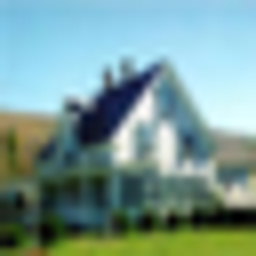

In [217]:
with open('/kaggle/working/data/cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('/kaggle/working/data/cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# классы по варианту
CLASSES = [37, 63, 28]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

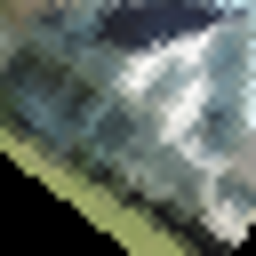

In [218]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.1),
    T.RandomAffine(degrees=45, translate=(0.3, 0.3), scale=(1.3, 1.7), shear=10)
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

## Гиперпараметры

In [219]:
# HIDDEN_SIZE = 512 # по умолчанию
# batch_size = 128 # по умолчанию
# LR=1e-3 # по умолчанию
# EPOCHS = 200 # по умолчанию

HIDDEN_SIZE = 512*2
batch_size = 256
LR=1e-3
EPOCHS = 130

In [220]:
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S")  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
print('ModelName =', MODEL_NAME)
pprint({"HIDDEN_SIZE": HIDDEN_SIZE, "BATCH_SIZE":batch_size, "LR":LR, "EPOCHS": EPOCHS})

ModelName = 08.05-07:53:40
{'BATCH_SIZE': 256, 'EPOCHS': 130, 'HIDDEN_SIZE': 1024, 'LR': 0.001}


In [221]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x79af8214c7c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x79af8214f0d0>}

## Модель

In [222]:
train_X.shape

# (1500, 32, 32, 3)
# 1500 картинок в виде матрицы 32х32, значением которой является вектор цвета пикселя - 3 числа 

(1500, 32, 32, 3)

In [223]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        # input (<batch_size>, 32, 32, 3) NHWC
        # input - это batch_size X-элементов из датасета Tensor.size(32, 32, 3)
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        # Тут картинка 1) нормализуется и
        # 2) превращается из Tensor.size(<batch_size>, 32,32,3) в строку Tensor.size(<batch_size>, 32*32*3 = 3072),
        return torch.flatten(x, start_dim=1) # NWHC -> NM

class Cifar100_AE(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_AE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size//2),
#             nn.ELU(),
#             nn.Linear(hidden_size//2, hidden_size//8),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
#             nn.Linear(hidden_size//8, hidden_size//2),
#             nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 32*32*3),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed

model = Cifar100_AE(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)
summary(model, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
               ELU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              Tanh-5                  [-1, 512]               0
            Linear-6                 [-1, 1024]         525,312
               ELU-7                 [-1, 1024]               0
            Linear-8                 [-1, 3072]       3,148,800
Total params: 7,345,664
Trainable params: 7,345,664
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 28.02
Estimated Total Size (MB): 28.12
----------------------------------------------------------------


In [224]:
%%script echo skipping

class LogShape(nn.Module):
    def forward(self, x):
        print('shape:', x.shape)
        return x
    
# Normalize из ЛР-2
# отличие - в порядке кодировки каналов (permute)
class Normalize2(nn.Module):
    def __init__(self, mean, std):
        super(Normalize2, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # NHWC -> NCHW

class Cifar100_CAE(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CAE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize2([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.encoder = nn.Sequential(            
            nn.Conv2d(3, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #LogShape(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # LogShape(),
            nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            # LogShape(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # LogShape(),
        )
        self.decoder = nn.Sequential(
             nn.ConvTranspose2d(64, 512, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ELU(),
            # LogShape(),
            nn.ConvTranspose2d(512, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            # LogShape(),
            nn.Tanh(),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed

model = Cifar100_CAE(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)

# тест архитектуры
# model.forward(torch.randn(1, 32, 32, 3).to(device))
summary(model, (32, 32, 3))

skipping


In [225]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## Обучение

Лучшая доля правильных ответов: 92.32321739275152 на 123 эпохе
Текущая доля правильных ответов: 91.28469054062187 (эпоха 130)


  0%|          | 0/780 [00:00<?, ?it/s]

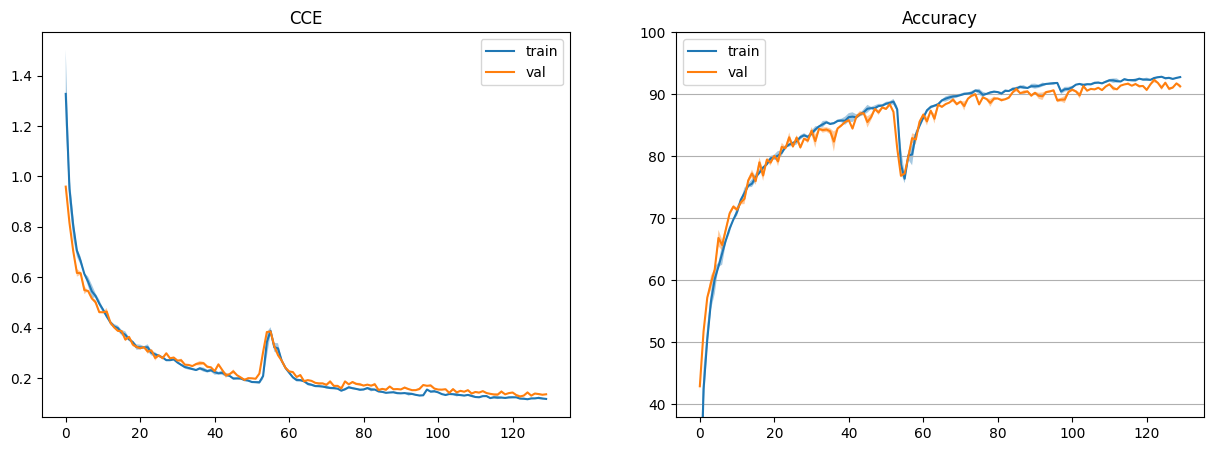

{'BATCH_SIZE': 256, 'EPOCHS': 130, 'HIDDEN_SIZE': 1024, 'LR': 0.001}
Обучение закончено за 121.09233903884888 секунд
Наилучшее значение метрики R2 получилось на 123 эпохе, для обучающей выборки - 92.63%, тестовой - 92.32%
train=92,63, test=92,32


<All keys matched successfully>

In [226]:
REDRAW_EVERY = max(int(EPOCHS / 25), 1)
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0

# для создания чекпоинта
best_acc = -10000
best_acc_train = 0
best_epoch_i = None
checkpoint_path = 'cifar_cnn_lab5.pth'

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, _ = batch
        # на GPU
        inputs, _ = inputs.to(device), _.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        # Для AE outputs - это tuple: torch.Size([128, 3072]) torch.Size([128, 4]) torch.Size([128, 3072])
        # для CAE - будет 128, 32, 32, 3. Чтобы сравнить в R2, "нужно выпрямить" flatten
        loss = criterion(outputs[0], outputs[2])
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        # немного переписал, чтобы работало и на AE, и на CAE
        # torch.flatten(torch.randn(128, 3, 32, 32), start_dim=1).shape # => 128, 3072
        # torch.flatten(torch.randn(128, 3072), start_dim=1).shape # => 128, 3072
        accuracy = r2_score(torch.flatten(outputs[2], start_dim=1).detach().cpu().numpy(),
                            torch.flatten(outputs[0], start_dim=1).detach().cpu().numpy())*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, _ = data
            # на GPU
            inputs, _ = inputs.to(device), _.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs[0], outputs[2])
            accuracy = r2_score(torch.flatten(outputs[2], start_dim=1).detach().cpu().numpy(),
                                torch.flatten(outputs[0], start_dim=1).detach().cpu().numpy())*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    
    if acc > best_acc:
        best_acc = acc
        best_acc_train = losses[-1][0][1]
        best_epoch_i = epoch
        torch.save(model.state_dict(), checkpoint_path)
        
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    
    print('Лучшая доля правильных ответов: %s на %s эпохе\n'
          'Текущая доля правильных ответов: %s (эпоха %s)' % (best_acc, best_epoch_i+1, acc, epoch+1))
    
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()

print('ModelName =', MODEL_NAME)
pprint({"HIDDEN_SIZE": HIDDEN_SIZE, "BATCH_SIZE":batch_size, "LR":LR, "EPOCHS": EPOCHS})
print('Обучение закончено за %s секунд' % passed)
print('Наилучшее значение метрики R2 получилось на %s эпохе, для обучающей выборки - %s%%, тестовой - %s%%' % (best_epoch_i+1, format(best_acc_train, ".2f"), format(best_acc, ".2f")))
print('train=%s, test=%s' %  (format(best_acc_train, "2.2f").replace('.', ','), format(best_acc, "2.2f").replace('.', ',')))
model.load_state_dict(torch.load(checkpoint_path))

## Получение результатов обученной модели

In [227]:
embeddings = []
colors = []
images = []
reconstructs = []
model.eval()
with torch.no_grad():
    for i, batch in enumerate(dataloader['test'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        out, embedding, norm = model(inputs)
        embeddings.append(embedding.detach().cpu().numpy())
        images.append(inputs.detach().cpu().numpy())
        reconstructs.append(out.detach().cpu().numpy())
        colors.append(labels.argmax(-1).detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
images = np.concatenate(images, axis=0)
reconstructs = np.concatenate(reconstructs, axis=0)
reconstructs = (reconstructs-reconstructs.min())/(reconstructs.max()-reconstructs.min())
colors = np.concatenate(colors, axis=0)

### Визуализация восстановленной картинки

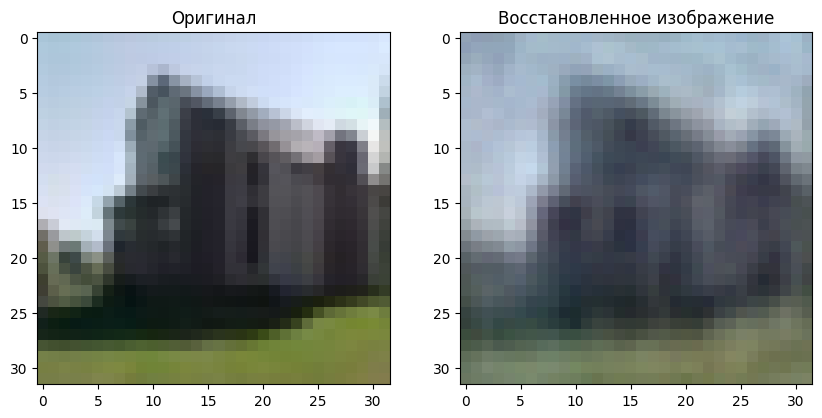

<function __main__.draw_comparision(index=0)>

In [228]:
def draw_comparision(index=0):
   fig, ax = plt.subplots(1, 2, figsize=(10, 5))
   ax[0].imshow(images[index].reshape(32,32,3)/255.)
   ax[1].imshow(reconstructs[index].reshape(32,32,3))
   ax[0].set_title('Оригинал')
   ax[1].set_title('Восстановленное изображение')

interact(draw_comparision, index=(0, len(images)))

## Визуализация эмбеддинга

In [229]:
# raise Exception('stop')

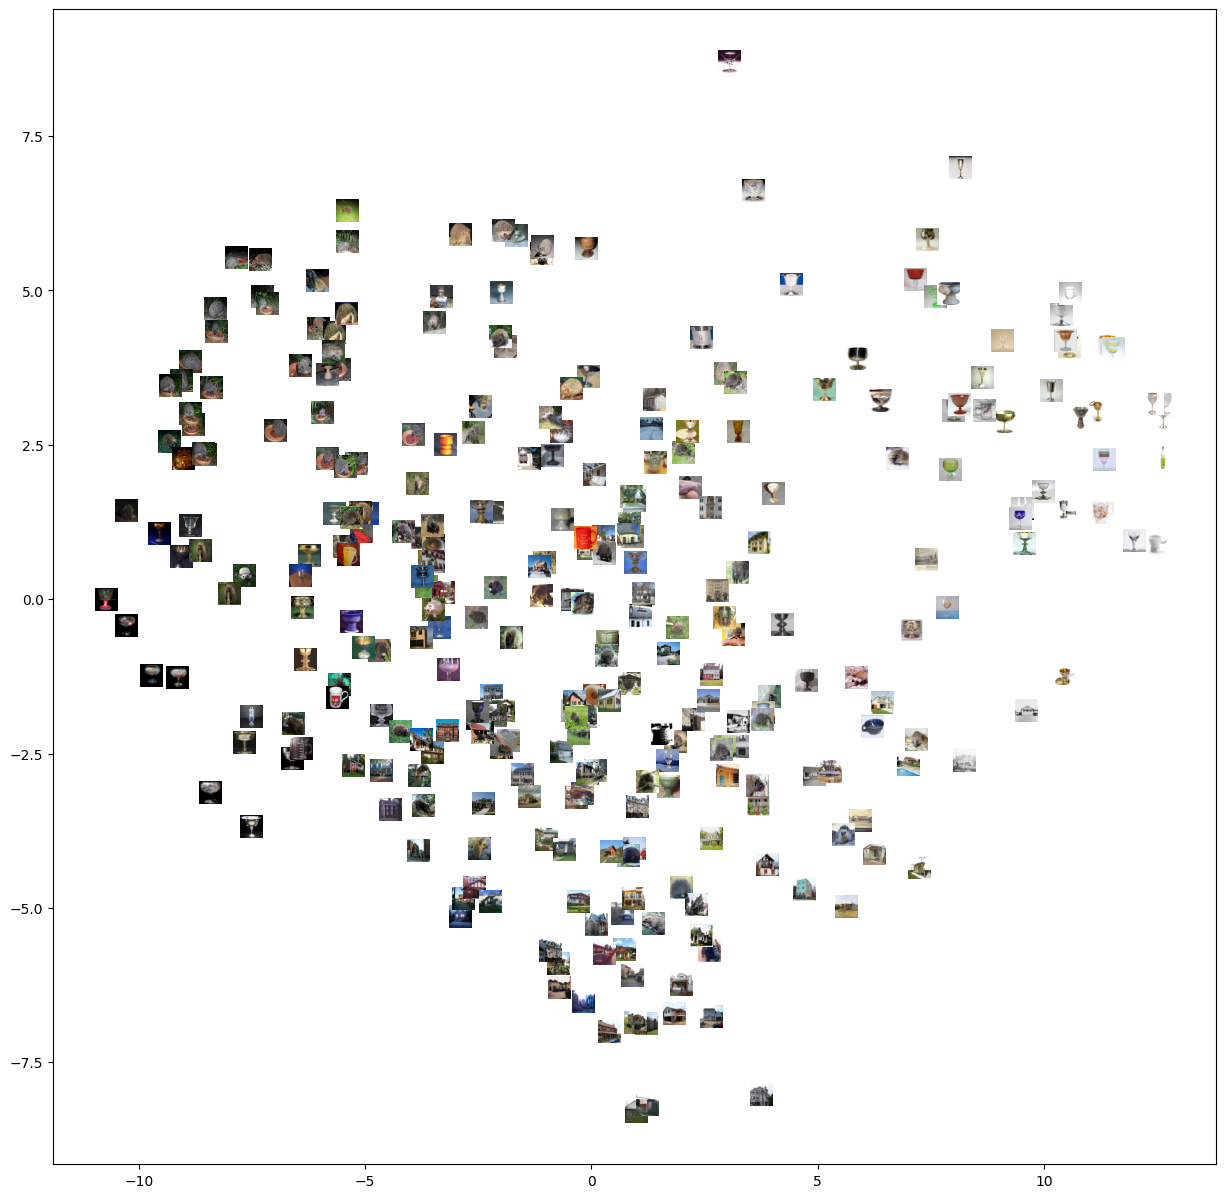

In [230]:
# Тут мы применяем уменьшение размерности к многомерному
# эмбеддингу, полученному из бутылочного горлышка автоэнкодера.
# Можете попробовать сделать число нейронов равное 2
# и тогда данный этап можно пропустить и написать просто:

projection = embeddings
projections = PCA(n_components=2).fit_transform(embeddings)

def implot(x, y, image, ax, zoom=1):
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
for img, x in zip(images, projections):
    img = img.reshape(32, 32, 3)/255.
    implot(x[0], x[1], img, ax=ax, zoom=0.5)

## Сохранение модели

In [231]:
PATH_ARCH = "models/lab5/" + MODEL_NAME + ".pt"
torch.save(model, PATH_ARCH)

# загрузка
# new_model = torch.load("/kaggle/input/lab5/"  + model_name + ".pt")

In [236]:
# 1 модель - 16 Мб
# !zip -r "models/models-lab5-$MODEL_NAME.zip" models/lab5 > /dev/null 2>&1
# см. размер перед скачиванием
!find . -maxdepth 1 -type f -ls

  1048599  28700 -rw-r--r--   1 root     root     29386196 May  8 07:55 ./cifar_cnn_lab5.pth
  1048592  18460 -rw-r--r--   1 root     root     18901257 May  8 05:33 ./state.db
